# Modified Cam-Clay

In this example, we implement and solve a **Modified Cam-Clay (MCC)** model using the `jaxmat` library.

```{admonition} Objectives
:class: important

The goal of this demo is to illustrate how to:

- Define an elasto-plastic constitutive model with mixed isotropic–kinematic hardening.

- Integrate the constitutive equations by solving an implicit system with plastic consistency conditions.

- Evaluate the model response for non-proportional load paths.
```

The workflow follows the same structure as in the [Green viscoplastic model demo](./Green_viscoplasticity.ipynb): we successively define the internal variables, the yield surface, the hardening law, and the constitutive update.
We then simulate several over-consolidation ratios (OCRs) to study the material’s transition from contractant to dilatant behavior.


## Model overview

The Modified Cam-Clay (MCC) yield function is defined as:

```{math}
f(\bsig, p_c) = \sqrt{(p-p_c)^2 + \left(\dfrac{q}{M}\right)^2}
```

where

- $p = -\frac{1}{3}\,\tr(\bsig)$ is the mean pressure,
- $q = \sqrt{\frac{3}{2}\bs:\bs}$ is the von Mises equivalent stress,
- $M$ is a material parameter describing the *critical state line* slope in the $(p,q)$ plane
- $p_c$ is a hardening variable called *critical pressure* ($2pc$ is the *preconsolidation pressure*).

Usually, we assume that the material possesses no tensile strength so that the yield surface lies only within the compressive stress region. This implies that the yield criterion is expressed as:

```{math}
\sqrt{(p-p_c)^2 + \left(\dfrac{q}{M}\right)^2} - p_c \leq 0
```

The preconsolidation pressure evolves with volumetric plastic strain $\varepsilon_v = \mathrm{tr}(\bepsp)$ according to the exponential hardening law:

```{math}
p_c(\varepsilon_v) = p_{c0}\exp(-\beta \varepsilon_v)
```

where $p_{c0}$ is the initial critical pressure and $\beta$ is a hardening rate coefficient.

```{attention}
The Modified Cam-Clay model exhibits *mixed hardening*:  the yield ellipse translates along the hydrostatic axis (kinematic part) and expands or contracts (isotropic part).  During compression ($\varepsilon_v < 0$), the material hardens as $p_c$ increases; during dilation ($\varepsilon_v > 0$), it softens.  This coupling naturally captures the contractant–dilatant transition observed in soils near the critical state.
```

## Model implementation

We now proceed to implement the model step by step with `jaxmat`.

In [1]:
import jax
import jax.numpy as jnp

jax.config.update("jax_platform_name", "cpu")

import jaxmat
import jaxmat.materials as jm
from jaxmat.tensors import SymmetricTensor2, dev
from jaxmat.tensors.utils import FischerBurmeister as FB
from jaxmat.loader import ImposedLoading, global_solve
import equinox as eqx
import optimistix as optx
from optax.tree_utils import tree_zeros_like
import matplotlib.pyplot as plt

We import the relevant `jax` and `jaxmat` modules, enabling automatic differentiation, batched tensor operations, and root-finding through `optimistix`. The Fischer–Burmeister (FB) function will be used to impose the Kuhn–Tucker complementarity conditions of plasticity in a (semi-)smooth way.

### Internal state definition

The internal variable for the Modified Cam-Clay model is the plastic strain tensor $\bepsp$.
We define a small subclass of `AbstractState` to store and update this tensor between time steps.

In [2]:
# Define internal state to store plastic strain
class InternalState(jaxmat.state.AbstractState):
    epsp: SymmetricTensor2 = eqx.field(default_factory=lambda: SymmetricTensor2())

### Yield surface

We now define the Cam-Clay yield surface. The class inherits from `AbstractPlasticSurface` and thus automatically computes the normal vector to the yield surface via its `normal` method. We simply need to implement the expression of the yield surface in the `__call__` dunder method. We decorate the latter with  the `safe_zero` decorator as described in the [](./Green_viscoplasticity.ipynb) demo.

In [3]:
class CamClaySurface(jm.AbstractPlasticSurface):
    M: float = eqx.field(converter=jnp.asarray)  # critical state line parameter

    @jm.safe_zero
    def __call__(self, sig, pc):
        p = -jnp.trace(sig) / 3
        s = dev(sig)
        q2 = 3.0 / 2.0 * jnp.vdot(s, s)
        return jnp.sqrt((pc - p) ** 2 + q2 / self.M**2)

### Hardening law

We next define the exponential hardening rule for the preconsolidation pressure:

In [4]:
class Hardening(eqx.Module):
    beta: float = eqx.field(converter=jnp.asarray)
    pc0: float = eqx.field(converter=jnp.asarray)

    def __call__(self, ep):
        return self.pc0 * jnp.exp(-self.beta * ep)

The function takes the volumetric plastic strain $\varepsilon_v$ as input and returns the corresponding $p_c$.

### Constitutive update

We now assemble all components into the main Modified Cam-Clay class. This class inherits from `SmallStrainBehavior` and defines the local integration algorithm to update the stress and state variables implicitly as follows:
The constitutive update proceeds first by defining the final stress expression from the known strain increment $\Delta\beps$ and the unknown plastic strain increment $\Delta\bepsp$.

The residual system enforcing the plastic flow rule and yield condition is then defined. Note that although the plastic multiplier increment $\Delta\lambda$ has not been defined as a state variable, it is an auxiliary unknown that we need to solve for. Moreover, we use the Fischer–Burmeister function `FB(x,y)` (see [Fischer-Burmeister function](./../computational.md)) to smoothly impose the complementarity condition between plastic consistency and plastic multiplier. The discretized system using an implicit Euler scheme is here to find $(\Delta\lambda,\Delta\bepsp)$ such that:

```{math}
\begin{align*}
\Delta\bepsp - \Delta \lambda \bn &= 0\\
\text{FB}(p_c-f(\bsig, p_c(\varepsilon^\text{p}_v)), \Delta\lambda) &= 0
\end{align*}
```

where $\varepsilon^\text{p}_v = \varepsilon^\text{p}_{v,n} + \Delta \varepsilon^\text{p}_v$ and where the last line is equivalent to:

```{math}
f(\bsig, p_c)-p_c \leq 0, \: \Delta\lambda\geq 0, \text{ and } \Delta\lambda(f(\bsig, p_c)-p_c) = 0
```

We solve the nonlinear system with `optimistix.root_find`, using automatic differentiation for the Jacobian and finally return the updated stress $\bsig$ and internal variable $\bepsp$.

In [5]:
class ModifiedCamClay(jm.SmallStrainBehavior):
    elasticity: jm.LinearElasticIsotropic
    plastic_surface: CamClaySurface
    hardening: Hardening
    internal_type = InternalState

    @eqx.filter_jit
    @eqx.debug.assert_max_traces(max_traces=1)
    def constitutive_update(self, eps, state, dt):
        eps_old = state.strain
        deps = eps - eps_old
        isv_old = state.internal
        epsp_old = isv_old.epsp
        sig_old = state.stress

        def eval_stress(deps, depsp):
            return sig_old + self.elasticity.C @ (deps - depsp)

        def solve_state(deps, epsp_old):

            def residual(dy, args):
                dlamb, depsp = dy
                sig = eval_stress(deps, depsp)
                epsp = epsp_old + depsp
                epspv = jnp.trace(epsp)
                pc = self.hardening(epspv)
                yield_criterion = self.plastic_surface(sig, pc) - pc
                n = self.plastic_surface.normal(sig, pc)
                res = depsp - dlamb * n, FB(-yield_criterion, dlamb)
                return (res, epsp)

            sol = optx.root_find(
                residual,
                self.solver,
                (0.0, tree_zeros_like(epsp_old)),
                has_aux=True,
                adjoint=self.adjoint,
            )
            dlamb, depsp = sol.value
            epsp = sol.aux
            sig = eval_stress(deps, depsp)
            return sig, epsp

        sig, epsp = solve_state(deps, epsp_old)
        isv = isv_old.update(epsp=epsp)
        new_state = state.update(strain=eps, stress=sig, internal=isv)
        return sig, new_state

## Evaluating the model

We instantiate below the MCC material by choosing $M=0.9$ and $\beta=30$, corresponding to typical clay parameters. The initial critical pressure is chosen here to be $p_{c0}=1\text{ MPa}$.

In [6]:
elasticity = jm.LinearElasticIsotropic(E=248.28, nu=0.241)
cc_surface = CamClaySurface(M=0.9)
pc0 = 1.0
hardening = Hardening(pc0=pc0, beta=30.0)
material = ModifiedCamClay(
    elasticity=elasticity, hardening=hardening, plastic_surface=cc_surface
)

## Load cases and initialization

We prepare a set of load cases corresponding to a triaxial compression test. In a first phase, for $0 \leq t\leq t_\text{cons}$, we define an isotropic consolidation load case, until reaching linearly with time a consolidation pressure $p_0$. The ratio $\text{OCR}=2p_{c0}/p_0$ defines the so-called Over-Consolidation Ratio (OCR). For each OCR, the end of the consolidation phase results in a hydrostatic strain state $\beps = -p_0/(3\kappa) \bI$ where $\kappa$ is the material bulk modulus. In total, we define six different OCRs from 2 to 16. Each case represents a different initial consolidation level: over-consolidated clays (large OCR) are stiffer and tend to dilate under shear, while normally consolidated clays (low OCR) tend to contract.

After this consolidation phase, we further increase the vertical compressive strain $-\varepsilon_{zz}$ while maintaining the lateral confining pressure, i.e. $\sigma_{xx}=\sigma_{yy}=-p_0$.

All 6 OCR load cases are integrated simultaneously as a batched simulation.

In [7]:
def compute_pq(sig):
    p = -jnp.trace(sig) / 3
    s = dev(sig)
    q = jnp.sqrt(3.0 / 2.0 * jnp.vdot(s, s))
    return p, q


OCR = jnp.linspace(2, 16, 6)
Nbatch = len(OCR)
p0_vals = 2 * pc0 / OCR
state = material.init_state(Nbatch)


eps_dot = 15e-2
Nsteps = 121
t_cons = 0.2
times = jnp.linspace(0, 1.2, Nsteps)

t = 0
imposed_eps = p0_vals / 3 / elasticity.kappa
p, q = jax.vmap(compute_pq)(state.stress)

results = jnp.zeros((Nsteps, Nbatch, 5))
for i, dt in enumerate(jnp.diff(times)):
    t += dt

    if t <= t_cons:
        pcons = p0_vals * t / t_cons
        loading = ImposedLoading(sigxx=-pcons, sigyy=-pcons, sigzz=-pcons)
    else:
        imposed_eps += eps_dot * dt
        loading = ImposedLoading(epszz=-imposed_eps, sigxx=-p0_vals, sigyy=-p0_vals)

    Eps = state.strain
    Eps, state, stats = global_solve(Eps, state, loading, material, dt)

    Sig = state.stress

    p, q = jax.vmap(compute_pq)(Sig)
    results = results.at[i + 1, :, 0].set(-Eps[:, 2, 2])
    results = results.at[i + 1, :, 1].set(jnp.trace(Eps, axis1=2))
    results = results.at[i + 1, :, 2].set(-Sig[:, 2, 2])
    results = results.at[i + 1, :, 3].set(p)
    results = results.at[i + 1, :, 4].set(q)

ValueError: INTERNAL: CpuCallback error calling callback: Traceback (most recent call last):
  File "/home/bleyerj/miniconda3/envs/jaxmat-env/lib/python3.14/site-packages/jax/_src/callback.py", line 784, in _wrapped_callback
  File "/home/bleyerj/miniconda3/envs/jaxmat-env/lib/python3.14/site-packages/jax/_src/callback.py", line 223, in _callback
  File "/home/bleyerj/miniconda3/envs/jaxmat-env/lib/python3.14/site-packages/jax/_src/callback.py", line 95, in pure_callback_impl
  File "/home/bleyerj/miniconda3/envs/jaxmat-env/lib/python3.14/site-packages/jax/_src/callback.py", line 70, in __call__
  File "/home/bleyerj/miniconda3/envs/jaxmat-env/lib/python3.14/site-packages/equinox/_errors.py", line 88, in raises
_EquinoxRuntimeError: A linear solver received non-finite (NaN or inf) input and cannot determine a 
solution. 

This means that you have a bug upstream of Lineax and should check the inputs to 
`lineax.linear_solve` for non-finite values.


--------------------
An error occurred during the runtime of your JAX program! Unfortunately you do not appear to be using `equinox.filter_jit` (perhaps you are using `jax.jit` instead?) and so further information about the error cannot be displayed. (Probably you are seeing a very large but uninformative error message right now.) Please wrap your program with `equinox.filter_jit`.
--------------------


Finally, we plot the corresponding stress and strain evolutions for the different OCR. The first plot shows the vertical stress/strain curve where we can clearly observe softening for the over-consolidated cases and hardening otherwise. The second plot shows the typical transition between contractance and dilatance during the softening evolutions. Finally, the last plot represents the stress paths in the $(p,q)$ space. The star symbols denote the final stress state for each cases which all fall on the critical state line of equation $q=Mp$.

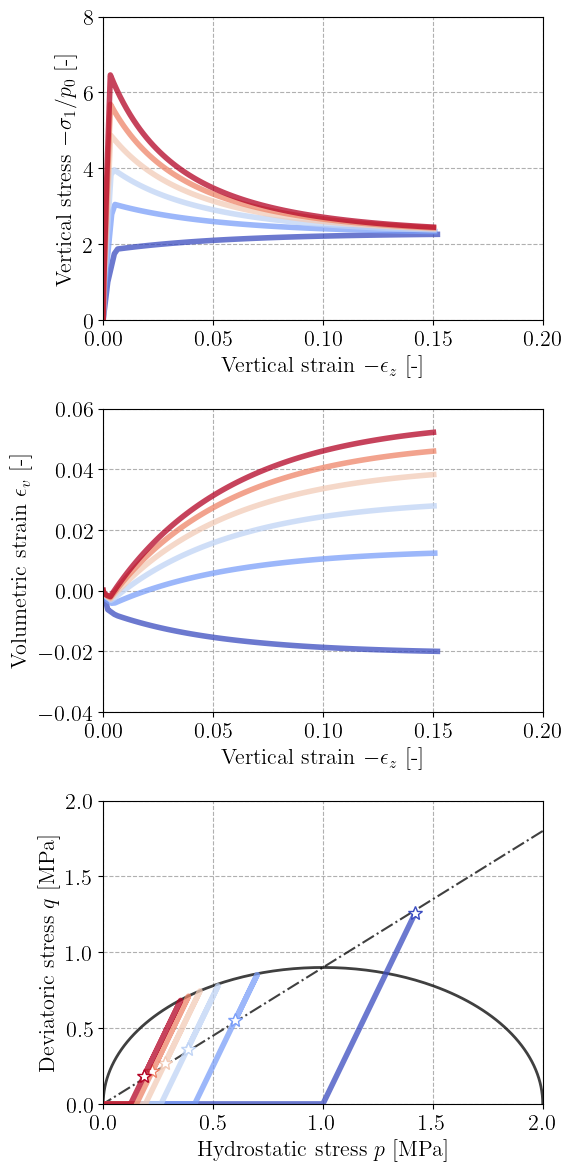

In [ ]:
cmap = plt.get_cmap("coolwarm")
colors = cmap(jnp.linspace(0, 1, Nbatch))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 12))
theta = jnp.linspace(0, jnp.pi, 200)
p = pc0 + pc0 * jnp.cos(theta)
q = cc_surface.M * pc0 * jnp.sin(theta)
ax3.plot(p, q, "-k", alpha=0.75)
ax3.plot(p, cc_surface.M * p, "-.k", linewidth=1.5, alpha=0.75)
for i in range(Nbatch):
    kwargs = {"color": colors[i], "linewidth": 4, "alpha": 0.75}
    ax1.plot(results[:, i, 0], results[:, i, 2] / p0_vals[i], **kwargs)
    ax1.set_xlabel(r"Vertical strain $-\epsilon_z$ [-]")
    ax1.set_ylabel(r"Vertical stress $-\sigma_1/p_0$ [-]")

    ax2.plot(results[:, i, 0], results[:, i, 1], **kwargs)
    ax2.set_xlabel(r"Vertical strain $-\epsilon_z$ [-]")
    ax2.set_ylabel(r"Volumetric strain $\epsilon_v$ [-]")

    ax3.plot(results[:, i, 3], results[:, i, 4], **kwargs)
    ax3.plot(
        results[-1, i, 3],
        results[-1, i, 4],
        "*",
        markersize=10,
        markerfacecolor="w",
        color=colors[i],
    )
    ax3.set_xlabel(r"Hydrostatic stress $p$ [MPa]")
    ax3.set_ylabel(r"Deviatoric stress $q$ [MPa]")
plt.tight_layout()
plt.show()